In [1]:
import keras
import numpy as np
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras import backend as K
from PIL import Image
from scipy.optimize import fmin_l_bfgs_b
from keras.backend.tensorflow_backend import set_session
from keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
from keras import layers
from keras.models import Model

Using TensorFlow backend.


# Image Transformation Net

In [2]:
K.clear_session()
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.25
init_op = tf.global_variables_initializer()
sess = tf.Session(config=config)
set_session(sess)

In [3]:
#residual block 
from keras import layers
from keras.models import Model

def residual_block(x, num):
    shortcut = x
    x = layers.Conv2D(128, (3, 3), strides=1, padding='same', name='resi_conv_%d_1' % num)(x)
    x = layers.BatchNormalization(name='resi_normal_%d_1' % num)(x)
    x = layers.Activation('relu', name='resi_relu_%d_1' % num)(x)
    x = layers.Conv2D(128, (3, 3), strides=1, padding='same', name='resi_conv_%d_2' % num)(x)
    x = layers.BatchNormalization(name='resi_normal_%d_2' % num)(x)
    m = layers.add([x, shortcut], name='resi_add_%d' % num)
    return m


def Convolution_block(x,filters,kernel_size,stride,i,activation):
    x = layers.Conv2D(filters,kernel_size, strides=stride, padding='same', name='conv_'+str(i))(x)
    x = layers.BatchNormalization(name='normal_%d' % i)(x)
    x = layers.Activation(activation, name='%s_%d' % (activation,i))(x)
    return x

def Convolution_block_T(x,filters,kernel_size,stride,i,activation):
    x = layers.Conv2DTranspose(filters,kernel_size, strides=stride, padding='same', name='conv_'+str(i))(x)
    x = layers.BatchNormalization(name='normal_%d' % i)(x)
    x = layers.Activation(activation, name='%s_%d' % (activation,i))(x)
    return x



def image_transform_model():
    image_size = (500,500,3)
    #Image transformation network
    input_origin = layers.Input(shape=image_size,name="input_origin")
    #the network
    c1 = Convolution_block(x= input_origin,
                           filters= 32,
                           kernel_size =(9,9),
                           stride = 1,
                           i=1,
                           activation='relu')

    c2 = Convolution_block(x= c1,
                           filters= 64,
                           kernel_size =(3,3),
                           stride = 2,
                           i=2,
                           activation='relu')

    c3 = Convolution_block(x= c2,
                           filters= 128,
                           kernel_size =(3,3),
                           stride = 2,
                           i=3,
                           activation='relu')

    r1 = residual_block(c3, 1)
    r2 = residual_block(r1, 2)
    r3 = residual_block(r2, 3)
    r4 = residual_block(r3, 4)
    r5 = residual_block(r4, 5)

    d1 = Convolution_block_T(x= r5,
                           filters= 64,
                           kernel_size =(3,3),
                           stride = 2,
                           i=4,
                           activation='relu')
    d2 = Convolution_block_T(x= d1,
                           filters= 32,
                           kernel_size =(3,3),
                           stride = 2,
                           i=5,
                           activation='relu')

    output = Convolution_block(x= d2,
                           filters= 3,
                           kernel_size =(9,9),
                           stride = 1,
                           i=6,
                           activation='tanh')

    model = Model([input_origin],[output])
    return model


In [4]:
model = image_transform_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_origin (InputLayer)       (None, 500, 500, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 500, 500, 32) 7808        input_origin[0][0]               
__________________________________________________________________________________________________
normal_1 (BatchNormalization)   (None, 500, 500, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
relu_1 (Activation)             (None, 500, 500, 32) 0           normal_1[0][0]                   
__________________________________________________________________________________________________
conv_2 (Co

# Load pre-trained weights and run

## Provide path to trained model and desired image here

In [5]:
model_weights_path = "../data/trained_weights/udnie_weights.h5"
content_path = "../data/content/bird.jpg"

In [6]:
model.load_weights(model_weights_path,by_name=True)

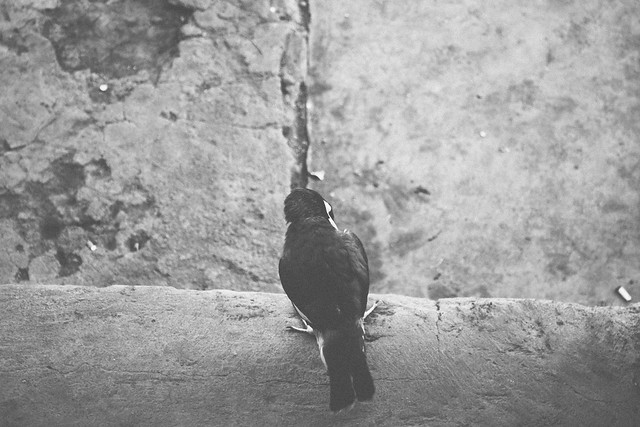

In [7]:
Image.open(content_path)

## Run and process output

In [8]:
from scipy.misc import imsave
def process_image(image_path=None,img = None,image_size=(500,500,3)):
    if image_path:
        img = load_img(image_path, target_size=image_size)
    else:
        img = img
    img = img_to_array(img)
    img_orig = img.copy()
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    img.astype('float32')
    return img
def deprocess_image(x):
    x = x.reshape((500, 500, 3))
    x= x*127.5+255/2
    #print(x.shape)
    x = x[:, :, ::-1]
    x = x.astype('uint8')
    return x

def display_img(i,x,style,is_val=False):
    # save current generated image
    img = x 
    if is_val:
        fname = '%s_%s_val.png' % (style,i)
    else:
        fname = '%s_%s.png' % (style,i)
    imsave(fname, img)
    print('Image saved as', fname)


## predict

In [9]:
content = process_image(image_path=content_path)
%time predict = model.predict(content)

CPU times: user 9.34 s, sys: 1.28 s, total: 10.6 s
Wall time: 1.74 s


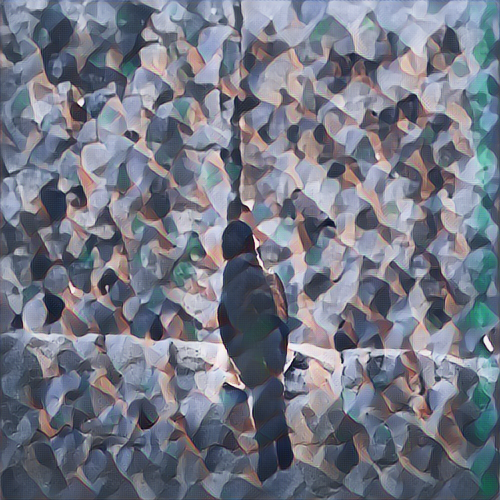

In [10]:
Image.fromarray(deprocess_image(predict))

In [ ]:
#Save image to disk
display_img("bird",deprocess_image(predict),"wave",is_val=False)

# Video Transfer

## Live stream

In [13]:
#Need to perform in loc
import cv2

cap = cv2.VideoCapture(0)
cv2.startWindowThread()
while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()
        # Display the resulting frame
    frame = cv2.resize(frame, dsize=(500,500), interpolation=cv2.INTER_CUBIC)
    content = process_image(img=frame)
    predict = (model.predict(content))
    predict = deprocess_image(predict)
    cv2.imshow('Video', predict)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

error: /Users/travis/build/skvark/opencv-python/opencv/modules/imgproc/src/resize.cpp:4044: error: (-215) ssize.width > 0 && ssize.height > 0 in function resize


## Video process


In [17]:
vid_path = "../data/content/cat_vid.mov"
vid_output_name = 'cat_wave'

In [18]:
import cv2
cap = cv2.VideoCapture(vid_path)
if (cap.isOpened() == False): 
    print("Unable to read camera feed")

In [21]:
out = cv2.VideoWriter(vid_output_name+".avi",cv2.VideoWriter_fourcc('M','J','P','G'), 30.0, (500*2,500))
count = 0 
while(True):
    ret, frame = cap.read()
    if ret == True:
        frame = cv2.resize(frame, dsize=(500, 500), interpolation=cv2.INTER_CUBIC)
        content = process_image(img=frame)
        predict = (model.predict(content))
        predict = deprocess_image(predict)
        out.write(np.concatenate((predict,frame.astype('uint8')),axis=1))           
    else:
        break
cap.release()
out.release()       